In [ ]:
import pandas as pd
import numpy as np


from tqdm.auto import tqdm
from statsmodels.tsa.arima_model import ARIMA

import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['axes.grid'] = True

In [ ]:
DATA_PATH = './data'

In [ ]:
# train_x = pd.read_csv(DATA_PATH  + "/train_x_df.csv")
# train_y = pd.read_csv(DATA_PATH  + "/train_y_df.csv")
test_x = pd.read_csv(DATA_PATH  + "/test_x_df.csv")


In [ ]:
# vwap과, open에서 vwap을 뺀 값인 diff를 계산합니다.
def make_vwap_and_diff(df):
    # 1) VAWP 계산

    # 일반적인 VWAP 공식에서 volume을 그대로 사용하지만, 여러번의 시도를 통해 tb_base_av 와 volume을 더했을 때 가장 좋은 volume이 나온다고 판단하여서 사용하였습니다.
    df["volume_tb_base_av"] = df["tb_base_av"] + df["volume"]

    # volume price
    '''
        시즌2 2위팀 방식 : open하나만을 사용하기 보다는 open(시가), high(고가), low(저가) 3개의 평균을 price로 사용
        code) df['volume_price'] = ((df['open'] + df['high'] + df['low']) / 3) * df['volume_tb_base_av']
    
        1차 수정 방식 :   (open + close)/2 = price 로 사용, 이유는 high와 low를 포함하는 값은 오차의 범위가 너무 커짐
        code) df['volume_price'] = ((df['open'] + df['close']) / 2) * df['volume_tb_base_av']
        
        2차 수정 방식 :   high + low /2를 추가 가격 데이터로 잡아 변동성을 반영하게 바꿈(매수 횟수를 늘리기 위해)
        code) df['volume_price'] = ((((df['high'] + df['low'])/2) +  df['open'] + df['close']) / 3) * df['volume_tb_base_av']
    '''

    df['volume_price'] = ((((df['high'] + df['low'])/2) +  df['open'] + df['close']) / 3) * df['volume_tb_base_av']

    # price와 volume의 곱의 합을 구해줍니다.
    df['volume_price_sum'] = df.groupby(['sample_id'])['volume_price'].apply(lambda x: x.cumsum())

    # volume의 합을 구해줍니다.
    df['volume_sum'] = df.groupby(['sample_id'])['volume_tb_base_av'].apply(lambda x: x.cumsum())

    # 2 변수의 나눗셈을 통해 vwap을 계산해줍니다.
    df['vwap'] = df['volume_price_sum'] / df['volume_sum']


    # 2) diff 계산
    # 매도수익이 open을 통해 이루어진다고 알려져있기 때문에 open에서 vwap을 뺀 값을 diff로 사용했습니다.
    df["diff"] = df["open"] - df["vwap"]

    return df


def calcBb(df, w=20, k=2):
    '''
    볼린저밴드를 구하는 공식에 20일 단순이동평균값을 이용할 때,
    close(종가)에 대한 20일 단순이동평균값을 이용하여 계산하는 방식과
    (close + high + low)/3 (종가, 고가,저가의 평균값)에 대한 20일 단순이동평균값을 이용하여 계산하는 방식이 존재합니다.

    그냥 일단 open 데이터로 함
    '''
    x = df['open']
    mean = x.rolling(w, min_periods=1).mean()
    std = x.rolling(w, min_periods=1).std()
    
    df['mildde_ballin'] = mean
    df['upper_ballin'] = mean + (k * std)
    df['lower_ballin'] = mean - (k * std)
    df['ballin_width'] = (2 * k * std) / mean
    
    return df
#     df.round({f'MBB{suffix}': 2, f'UBB{suffix}': 2, f'LBB{suffix}': 2})

In [ ]:
# 데이터 프레임에서 sample_id 에 따른 open을 반환하는 함수입니다.
def get_open(df,sample_id):
    
    return df[df["sample_id"] == sample_id]['open'].values
    

In [ ]:
# 데이터 프레임에서 sample_id 에 따른 VWAP을 반환하는 함수입니다.
def get_vwap(df,sample_id):
    
    return df[df["sample_id"] == sample_id]['vwap'].values
    

In [ ]:
# 데이터 프레임에서 sample_id 에 따른 diff 반환하는 함수입니다.
def get_diff(df,sample_id):
    
    return df[df["sample_id"] == sample_id]['diff'].values
    

In [ ]:
# 데이터 프레임에서 sample_id 에 따른 rsi 반환하는 함수입니다.
def get_rsi(df,sample_id):
    
    return df[df["sample_id"] == sample_id]['rsi'].values
    

In [ ]:
# 데이터 프레임에서 sample_id 에 따른 col_name 값을 반환하는 함수입니다.
def get_series(df,sample_id, col_name):
    
    return df[df["sample_id"] == sample_id][col_name].values
    

In [ ]:
# 데이터 프레임에서 sample_id 에 따른 col_name 값을 반환하는 함수입니다.
def get_ubb(df,sample_id):
    
    return df[df["sample_id"] == sample_id]['upper_ballin'].dropna().values

# 데이터 프레임에서 sample_id 에 따른 col_name 값을 반환하는 함수입니다.
def get_lbb(df,sample_id):
    
    return df[df["sample_id"] == sample_id]['lower_ballin'].dropna().values

# 데이터 프레임에서 sample_id 에 따른 col_name 값을 반환하는 함수입니다.
def get_mbb(df,sample_id):
    
    return df[df["sample_id"] == sample_id]['mildde_ballin'].dropna().values

# 데이터 프레임에서 sample_id 에 따른 col_name 값을 반환하는 함수입니다.
def get_bbw(df,sample_id):
    
    return df[df["sample_id"] == sample_id]['ballin_width'].dropna().values


In [ ]:
# RSI를 만들어줍니다.
# 상승분, 하락분의 평균은 일반적으로 14일을 기준으로 생성합니다.
'''
    일반적인 RSI 방식 : 상승분, 하락분의 평균은 일반적으로 14일을 기준으로 생성
    
    1차 수정 방식 :     상승분, 하락분의 평균을 14일 기준으로 하지 않고, 25일기준으로 하여 안정성 향상

    2차 수정 방식 :     9일 기준으로 변동성 더 취해서, 매수 횟수를 늘림 (3일 이내와 같이 너무 단기간은 오히려 별로임)
'''
def make_rsi(df, period = 16):

    # 전일 대비 상승분을 계산해줍니다. - 상승분이 0보다 크면 상승분을 넣고, 0보다 작거나 같으면 0을 넣어줍니다.
    df["U"] = np.where(df.groupby(["sample_id"])["open"].diff(1) > 0, df.groupby(["sample_id"])["open"].diff(1), 0)

    # 전일 대비 하락분을 계산해줍니다. - 하락분이 0보다 작으면 하락분 * -1을 넣고, 0보다 크거나 같으면 0을 넣어줍니다.
    df["D"] = np.where(df.groupby(["sample_id"])["open"].diff(1) < 0, df.groupby(["sample_id"])["open"].diff(1) *(-1), 0)


    # 전일 대비 상승분의 평균을 계산해줍니다.
    ud_df = pd.DataFrame()
    ud_df["sample_id"] = df["sample_id"]
    ud_df["U"] = df["U"]
    ud_df["D"] = df["D"]

    # 상승분의 14일 평균을 구해줍니다.
    df["AU"] = ud_df.groupby(["sample_id"])["U"].rolling( window=period, min_periods=period ).mean().reset_index()["U"]
    # 하락분의 14일 평균을 구해줍니다.
    df["AD"] = ud_df.groupby(["sample_id"])["D"].rolling( window=period, min_periods=period ).mean().reset_index()["D"]


    # AU / (AU + AD) 의 백분율을 RSI 로 계산해줍니다.
    RSI = df["AU"] / (df["AU"] + df["AD"]) * 100
    
    df["rsi"] = RSI
    
    return df
    

In [ ]:
# 1. train, test의 sample_id 목록을 저장합니다.
TEST_SAMPLE_ID_LIST = test_x["sample_id"].unique().tolist()


In [ ]:
# 2. VWAP, diff 를 만들어줍니다.
test_x = make_vwap_and_diff(test_x)

In [ ]:
# 3. rsi 를 만들어줍니다.
test_x = make_rsi(test_x, 25)

In [ ]:
# 4. Ballinger Bands 를 만들어줍니다.
test_x = test_x.groupby(['sample_id']).apply(lambda x: calcBb(x, 20, 2))

In [ ]:
# temp_df = temp_data[temp_data['sample_id'] == 7954]

# ax1 = temp_df[['open', 'mildde_ballin','upper_ballin', 'lower_ballin']].plot(kind='line')
# plt.show()

In [ ]:
# w = 20
# h = 10

# start_p = 500
# end_p = 700

# # fig = plt.figure(dpi=300)
# fig, ax1 = plt.subplots(figsize=(w, h), dpi=300)

# plt.title('Ballinger Bands',fontsize = 25,pad=20)
# # ax = temp_df[1:][['open', 'mildde_ballin','upper_ballin', 'lower_ballin']].plot(kind='line')

# ax1.plot(temp_df[start_p:end_p][['time']], temp_df[start_p:end_p][['open', 'mildde_ballin','upper_ballin', 'lower_ballin']])
# # plt.legend(loc=0)

# plt.grid()
# plt.xticks(rotation=90)

# # ax.axes.xaxis.set_ticks([])

# ax2 = ax1.twinx()
# ax2.plot(temp_df[start_p:end_p][['time']],temp_df[start_p:end_p][['ballin_width']], 'b', alpha=0.3)
# # ax2 = temp_df[1:][['ballin_width']].plot(kind='bar',ax=ax1, alpha=0.2, color='blue')
# # ax2.axes.xaxis.set_ticks([])

# # ax2.axhline(y=6,linewidth=1, color='r')
# # ax2.axhline(y=7,linewidth=1, color='r')
# plt.tight_layout()
# plt.savefig('./results/strategy3')
# plt.show()

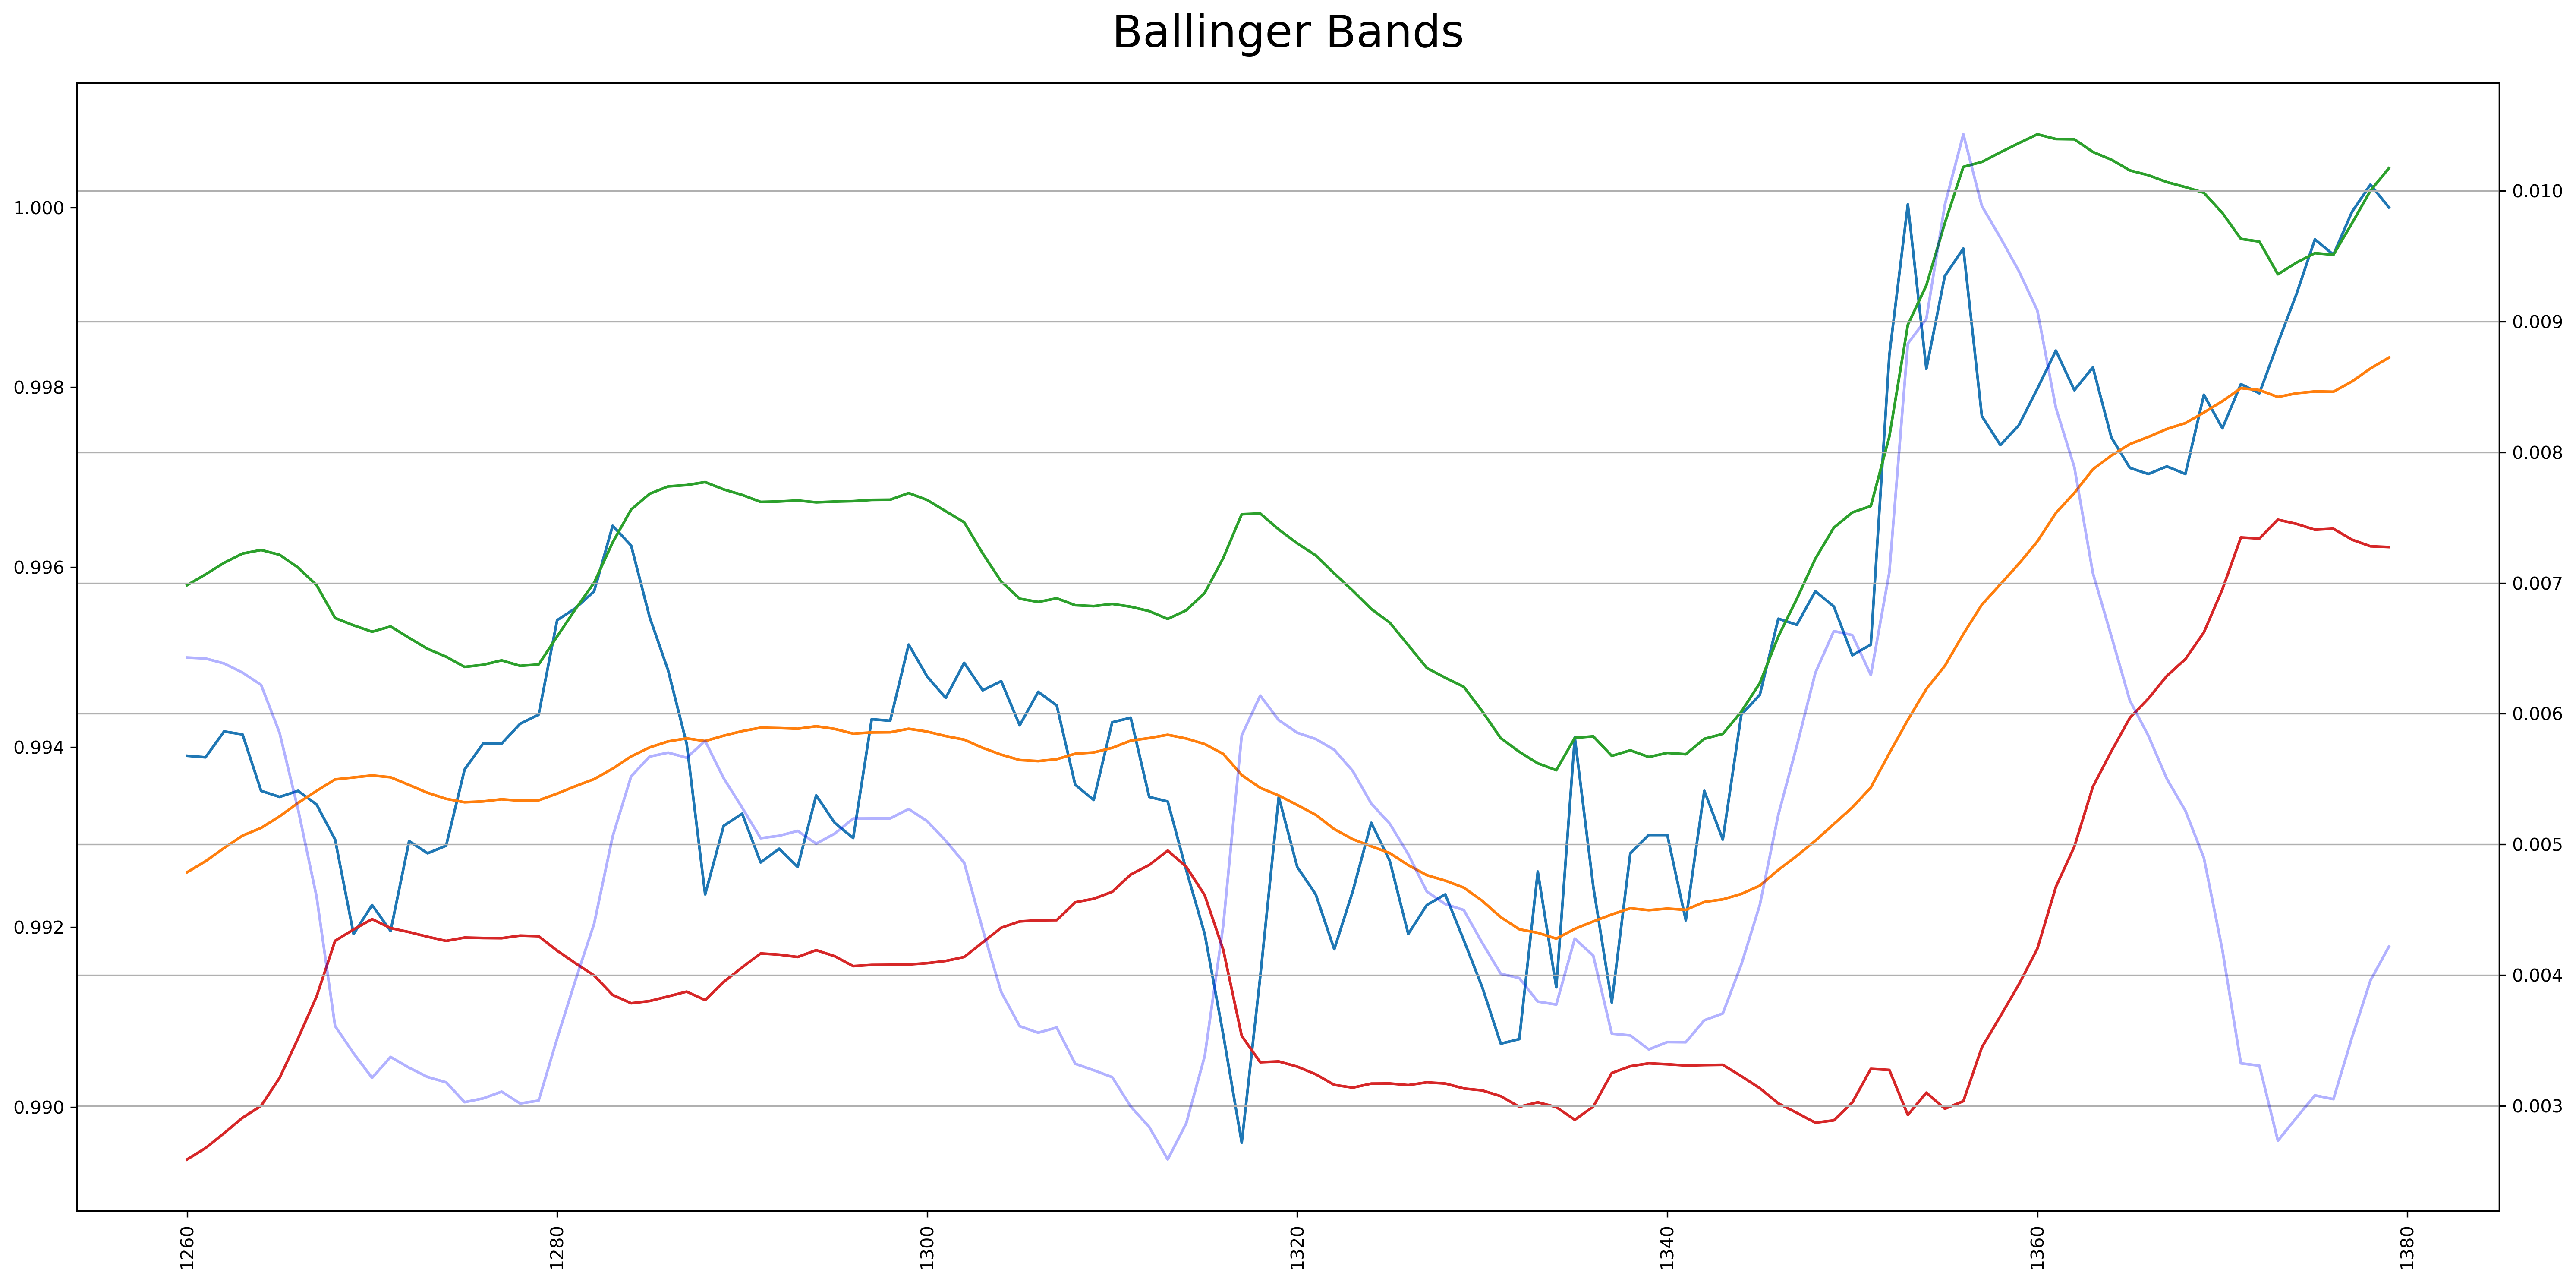

In [ ]:
w = 20
h = 10
# fig = plt.figure(dpi=300)
fig, ax1 = plt.subplots(figsize=(w, h), dpi=300)

plt.title('Ballinger Bands',fontsize = 25,pad=20)
# ax = temp_df[1:][['open', 'mildde_ballin','upper_ballin', 'lower_ballin']].plot(kind='line')

ax1.plot(temp_df[-120:][['time']], temp_df[-120:][['open', 'mildde_ballin','upper_ballin', 'lower_ballin']])
# plt.legend(loc=0)

plt.grid()
plt.xticks(rotation=90)

# ax.axes.xaxis.set_ticks([])

ax2 = ax1.twinx()
ax2.plot(temp_df[-120:][['time']],temp_df[-120:][['ballin_width']], 'b', alpha=0.3)
# ax2 = temp_df[1:][['ballin_width']].plot(kind='bar',ax=ax1, alpha=0.2, color='blue')
# ax2.axes.xaxis.set_ticks([])

# ax2.axhline(y=6,linewidth=1, color='r')
# ax2.axhline(y=7,linewidth=1, color='r')
plt.tight_layout()
plt.show()

In [ ]:
for sample_id in tqdm(TEST_SAMPLE_ID_LIST):

    # 1. 데이터 로드
    # 1) diff - 학습에 사용
    diff_x = get_diff(test_x, sample_id)

    # 2) vwap - 보조 지표로 사용
    vwap_series = get_vwap(test_x, sample_id)

    # 3) rsi - 보조 지표로 사용
    rsi_series = get_rsi(test_x, sample_id)

    # 4) Ballinger Bands - 보조 지표로 사용
    open_series = get_open(test_x, sample_id)
    ubb_series = get_ubb(test_x, sample_id)
    lbb_series = get_lbb(test_x, sample_id)
    bbw_series = get_bbw(test_x, sample_id)
    
    break;

  0%|          | 0/760 [00:00<?, ?it/s]

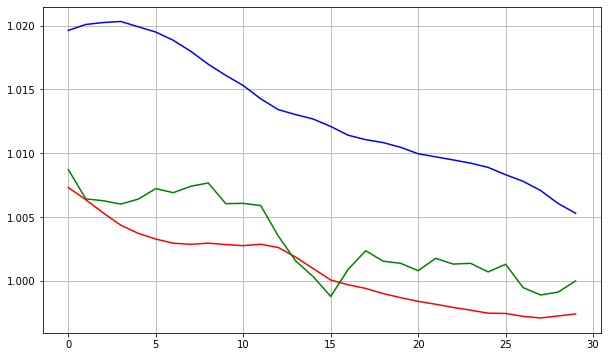

In [ ]:
plt.plot(ubb_series[-30:], 'b')
plt.plot(lbb_series[-30:], 'r')
plt.plot(open_series[-30:], 'g')


In [ ]:
# 상단 터치 = 가격 - 상단 캡이 양수인 경우 => 가격이 추세선 보다 위에 있음
upper_touch_series = (open_series[-30:] - ubb_series[-30:]) > 0

In [ ]:
upper_touch_series

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
# 하단 터치 =  - 가격 - 하단 지지가 음수인 경우 => 가격이 지지선 밑에 있음
lower_touch_series = (open_series[-30:] - lbb_series[-30:]) < 0

In [ ]:
lower_touch_series

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
lower_touch_series.argmax()

13

In [ ]:
print("50th percentile of arr : ",
       np.percentile(bbw_series, 20))

50th percentile of arr :  0.004026716216670073


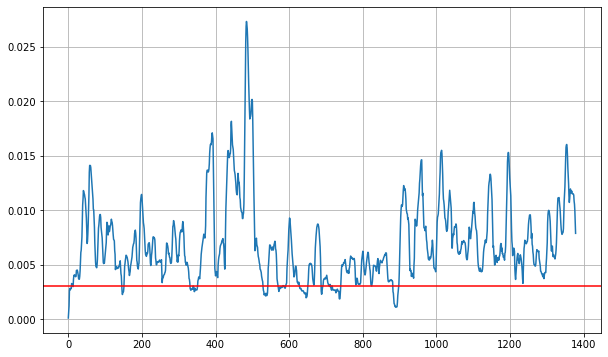

In [ ]:
plt.plot(bbw_series)
plt.axhline(np.percentile(bbw_series, 10), color='red')

In [ ]:
bbw_threshold = np.percentile(bbw_series, 10)

In [ ]:
result = []

for sample_id in tqdm(TEST_SAMPLE_ID_LIST):

    # 1. 데이터 로드
    # 1) diff - 학습에 사용
    diff_x = get_diff(test_x, sample_id)

    # 2) vwap - 보조 지표로 사용
    vwap_series = get_vwap(test_x, sample_id)

    # 3) rsi - 보조 지표로 사용
    rsi_series = get_rsi(test_x, sample_id)

    # 4) Ballinger Bands - 보조 지표로 사용
    ubb_series = get_ubb(test_x, sample_id)
    lbb_series = get_lbb(test_x, sample_id)
    mbb_series = get_mbb(test_x, sample_id)
    
    bbw_series = get_bbw(test_x, sample_id)
    bbw_threshold = np.percentile(bbw_series, 10)

    # 2. ARIMA
    # 1) 모델 정의
    ARIMA_MODEL = {}
    ARIMA_MODEL_FIT = {}

    # 2) AR 모델 적용
    try:
        ARIMA_MODEL = ARIMA(diff_x, order = (4,0,1))
        ARIMA_MODEL_FIT = ARIMA_MODEL.fit(trend = 'nc', full_output = True, disp = True)

    # 3) 수렴하지 않을 경우 p d q 를 1, 1, 0으로 사용
    except:
        ARIMA_MODEL = ARIMA(diff_x, order = (1,1,0))
        ARIMA_MODEL_FIT = ARIMA_MODEL.fit(trend = 'nc', full_output = True, disp = True)

    # 4) ARIMA 예측
    ARIMA_FORECAST  = ARIMA_MODEL_FIT.predict(1,120, typ='levels')


    # 3. 데이처 처리
    # 1) 최대 부분인 인덱스를 찾는데 해당 시점에 매도를 진행합니다.
    sell_time = np.argmax(ARIMA_FORECAST)

    # 2) 최대값을 찾습니다.
    max_val = np.max(ARIMA_FORECAST)
    
    # 3) vwap의 마지막 값을 가져옵니다.
    vwap_last_val = vwap_series[-1]
    rsi_last_val = rsi_series[-1]


    # 4. 투자 전략
    buy_quantity = 0

    # 1) 최대값이 0 보다 크면 가격이 vwap 보다 크다는 의미로, 투자합니다.
    if  max_val > 0:
        buy_quantity = 1
        
    # 2) 만약 vwap 마지막 값이, 1보다 크면 가격이 1보다 작다는 의미로 하향세이기 때문에 투자하지 않습니다.
    if vwap_last_val > 1 and sell_time < 50:
        buy_quantity = 0

    '''
    # 3) 만약 rsi의 값이 65 보다 크면, 초과매수 상태로 판단하여 투자하지 않습니다.
    # 07.05 22:29 ris 값이 75 보다 크면 초과매수로 판단하도록 수정 (변동성 최대한 투입)
    # 07.11 RSI 상단 터치후 sell time rest 기간이 50분 인데 이게 적절한 것일지 의문
    '''
    # 3) 만약 rsi의 값이 65 보다 크면, 초과매수 상태로 판단하여 투자하지 않습니다.
    if rsi_last_val > 75 and sell_time < 50:
        buy_quantity = 0

        
        
    '''
    추가 적용 전략 1) Ballinger Bands
    과거 30분 history에 상단 터치시 매수 = 0
    과거 30분 history에 하단 터치시 매수 유지
    
    BBW 가 P10 인 상태에서는 상단 터치시 매수로 변경(추세변환), 하단 터치시 매도로 변경(추세변환)
    '''
    # 볼린저 밴드 전략. 1
    threshold_indices = np.argwhere(bbw_series[-30:] <= bbw_threshold)
    if(len(threshold_indices) > 0):
        '''
        bbw가 squeeze되는 구간이 있는 경우, 상하단 터치 확인 후 매수, 매도
        '''
        for idx in threshold_indices:
            # get squuezed term  index
            buy_idx = idx[0]
            
            # 하단 터치 확인 => 하락 추세 변환
            if(lower_touch_series[buy_idx] == True):
                # 하락이 예상되므로 매도
                buy_quantity = 0
            if(upper_touch_series[buy_idx] == True):
                # 상승이 예상되므로 매수
                buy_quantity = 1

    # 볼린저 밴드 전략. 2
    '''
    # 상단 터치 = 가격 - 상단 캡이 양수인 경우 => 가격이 추세선 보다 위에 있음 => 과매수 구간
    # 하단 터치 =  - 가격 - 하단 지지가 음수인 경우 => 가격이 지지선 밑에 있음 => 이때도 사라고 바꿔줘야 할까..? => 현재는 주석처리
    '''
    if(upper_touch_series.sum() > 0):
         buy_quantity = 0
    
    # 하단 터치 =  - 가격 - 하단 지지가 음수인 경우 => 가격이 지지선 밑에 있음 => 이때도 사라고 바꿔줘야 할까..?
    # if(lower_touch_series.sum() > 0):
    #     buy_quantity = 1
    

    # 5. 결과
    result_list = [
                   sample_id,
                   buy_quantity,
                   sell_time
                  ]

    result.append(result_list)
    

  0%|          | 0/760 [00:00<?, ?it/s]

In [ ]:
# 1. 학습 결과를 데이터 프레임으로 만듭니다.

submit_columns = [
                  "sample_id", 
                  "buy_quantity", 
                  "sell_time"
                  ]


submit = pd.DataFrame(data=result, columns=submit_columns)


In [ ]:
# 2. 결과 데이터 프레임 확인
submit.head(10)

,sample_id,buy_quantity,sell_time
0,7929,1,117
1,7930,1,48
2,7931,1,31
3,7932,0,22
4,7933,0,19
5,7934,1,116
6,7935,1,91
7,7936,1,119
8,7937,1,119
9,7938,1,61


In [ ]:
# 3. 투자 개수 확인
submit[submit["buy_quantity"] == 1].shape[0]

568

In [ ]:
# 4. sell_time 50미만에서 구매하는 개수 확인
cond1 = (submit["buy_quantity"] == 1)
cond2 = (submit["sell_time"] < 50)

submit[cond1 & cond2].shape[0]


140

In [ ]:
# 파일의 이름을 지정해줍니다.
SUBMIT_PATH = './results'
FILE_NAME = "/0711_ARIMA_DIFF_VWAP_RSI_75_UNDER_50_SUBMIT.csv"

In [ ]:
# 제출경로에 파일을 생성해줍니다.
RESULT_PATH = SUBMIT_PATH + FILE_NAME
submit.to_csv(RESULT_PATH, index=False)
